## Station Prediction

This code bring two parts together:
* station_exploration.ipynb
* era-int_NAO_prediction.ipynb

In [1]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, addcyclic, shiftgrid
import pymongo
from pprint import pprint
from datetime import datetime, timedelta, date
import pandas as pd
from sklearn.decomposition import PCA
import sklearn.linear_model as skl_lm
import gdal as gdl
import matplotlib.mlab as ml
import cartopy.crs as ccrs
import plotly.graph_objs as go
import plotly.offline as py
from functools import reduce
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC

py.init_notebook_mode(connected=True) # for live plot
pd.set_option('display.notebook_repr_html', False)
%matplotlib inline
plt.style.use('seaborn-white')

In [2]:
mongo_host_local = 'mongodb://localhost:27017/'
mg = pymongo.MongoClient(mongo_host_local)

In [3]:
db = mg.ECMWF
db.collection_names()

['system.indexes',
 'ERAINT_grid',
 'ERAINT_lores_grid',
 'ERAINT_lores_monthly_anom',
 'ERAINT_monthly',
 'ERAINT_lores_monthly']

In [4]:
ERA_vers = 'lores'
if (ERA_vers == 'hires'):
    col_dat = 'ERAINT_monthly'
    col_anom = 'ERAINT_monthly_anom'
    col_grid = 'ERAINT_grid'
    resolution = 0.25
elif (ERA_vers == 'lores'):
    col_dat = 'ERAINT_lores_monthly'
    col_anom = 'ERAINT_lores_monthly_anom'
    col_grid = 'ERAINT_lores_grid'
    resolution = 2.5

con_grid = db[col_grid]
con_anom = db[col_anom]

## Name of variables:

* 'ci':  Sea-ice cover [0-1]
* 'sst': Sea surface temperature [K]
* 'istl1': Ice temp layer1 [K]
* 'sp': Surface pressure [Pa]
* 'stl1': Soil temp lev1 [K]
* 'msl': Mean SLP [Pa]
* 'u10': wind-u [m/s]
* 'v10': 
* 't2m': 2m temp [K]
* 'd2m': 2m dewpoint temp.[K]
* 'al': Surface albedo [0-1]
* 'lcc': Low cloud cover [0-1]
* 'mcc': Medium cloud cover [0-1]
* 'hcc': High cloud cover [0-1]
* 'si10': 10m wind speed [m/s]
* 'skt': Skin temperature [K]
* 'blh': Boundary layer hgt [m]
* 'ishf': Inst.surf.sensbl.heatflux [W/m2]
* 'ie': Instantaneous moisture flux [kg*m^-2*s^-1]
* 'z70': Geopot. height @70hPa [m]

In [5]:
# Names of candidate variables:
fo0 = con_anom.find({}, {'_id': 0, 'year': 0, 'month': 0, 'date': 0, 'id_grid': 0}).limit(1)
fo_df = pd.DataFrame(list(fo0))
all_varnames = list(fo_df)
all_varnames

['al',
 'blh',
 'ci',
 'd2m',
 'hcc',
 'ie',
 'ishf',
 'istl1',
 'lcc',
 'mcc',
 'msl',
 'si10',
 'skt',
 'sp',
 'sst',
 'stl1',
 't2m',
 'u10',
 'v10',
 'z70']

# Get Predictors

In [6]:
# Query anomalies for a variable for each input grid cells
def queryAnom(this_variable, this_grid_df):
    # Query data anomalies
    grid_ids = this_grid_df.id_grid.values
    res = con_anom.aggregate(pipeline=[ 
    {"$project": {"id_grid": 1, "date": 1, this_variable: 1, "month": {"$month": "$date"}}},
    {"$match": {"month": {"$in": [9, 10, 11, 12, 1, 2]},
                "id_grid": {"$in": grid_ids.tolist()} }},
    {"$project": {"_id": 0, "id_grid": 1, "date": 1, this_variable: 1}} ])    
    anom_df = pd.DataFrame(list(res))
    return anom_df

In [7]:
# Query grid cells for NAO calculation
poly1 = [list(reversed([ [-50,25], [-50,55], [10,55],[ 10,25], [-50,25]]))]
poly2 = [list(reversed([ [-40, 55], [-40, 85], [20, 85], [20, 55], [-40, 55]]))]
def getGridIds(this_polygon):
    geo_qry = {"loc": 
               {"$geoWithin": {
                   "$geometry": {
                       "type": "Polygon",
                       "coordinates": this_polygon
                   }
               }}}

    res = con_grid.find(filter = geo_qry, projection = {"_id":0, "id_grid": 1, "loc": 1})
    grid_df = pd.DataFrame(list(res))
    return grid_df
grid_df1 = getGridIds(poly1)
grid_ids1 = grid_df1.id_grid.values
grid_df2 = getGridIds(poly2)
grid_ids2 = grid_df2.id_grid.values

In [8]:
# Region to retrieve Niño 3.4 index for SST
# Niño 3.4 region: stretches from the 120th to 170th meridians west longitude astride 
# the equator five degrees of latitude on either side (Wikipedia)
poly_Nino = [list(reversed([ [-170,-5], [-170,5],[-120,5], [-120,-5], [-170,-5]]))]
grid_df_Nino = getGridIds(poly_Nino)
grid_ids_Nino = grid_df_Nino.id_grid.values
anom_sst_df = queryAnom(this_variable='sst', this_grid_df=grid_df_Nino)
nino_df0 = anom_sst_df[['date', 'sst']].groupby('date').mean().reset_index().rename(columns={'sst':'Nino'})
nino_df0.head()

        date      Nino
0 1979-01-01  0.149061
1 1979-02-01  0.114270
2 1979-09-01 -0.320141
3 1979-10-01 -0.224291
4 1979-11-01 -0.295341

In [9]:
# Generic function to query grid ids above a given latitude
def genCircle(start_lon, stop_lon, lat, decreasing): 
    res = map(lambda x:[int(x), lat],
              sorted(np.arange(start=start_lon, stop=stop_lon+1), reverse=decreasing))
    return list(res)

def queryGrids(aboveLat):
    this_box = {'lonmin': -180, 'lonmax': 180, 'latmin': aboveLat, 'latmax': 90}
    circle_north_pos = genCircle(start_lon = this_box['lonmin'], stop_lon = this_box['lonmax'], 
                                  lat = this_box['latmax'], decreasing = False)
    circle_south_neg = genCircle(start_lon = this_box['lonmin'], stop_lon = this_box['lonmax'], 
                                lat = this_box['latmin'],  decreasing = True)
    slp_poly = [[this_box['lonmin'], this_box['latmin']]]
    slp_poly.extend(circle_north_pos)
    slp_poly.extend(circle_south_neg)
    this_polygon = slp_poly
    
    if aboveLat > 0:
        geo_qry = {"loc": 
               {"$geoWithin": {
                   "$geometry": {
                       "type": "Polygon",
                       "coordinates": [this_polygon]
               }}}}
    else: # case of a big polygon larger than one hemisphere
        geo_qry = {"loc": 
               {"$geoWithin": {
                   "$geometry": {
                       "type": "Polygon",
                       "coordinates": [list(reversed(this_polygon))], # the orientation matters
                       "crs": {
                           "type": "name", 
                           "properties": { "name": "urn:x-mongodb:crs:strictwinding:EPSG:4326" }
                       }
                   }
               }}}
        
    res = con_grid.find(filter = geo_qry, projection = {"_id":0, "id_grid": 1, "loc": 1})
    grid_df = pd.DataFrame(list(res))
    return grid_df

grid_df_20N = queryGrids(aboveLat=20)
grid_df_20S = queryGrids(aboveLat=-20)

# Get PCA scores

In [10]:
# Generic function to query grid ids above a given latitude
def genCircle(start_lon, stop_lon, lat, decreasing): 
    res = map(lambda x:[int(x), lat],
              sorted(np.arange(start=start_lon, stop=stop_lon+1), reverse=decreasing))
    return list(res)

def queryGrids(aboveLat):
    this_box = {'lonmin': -180, 'lonmax': 180, 'latmin': aboveLat, 'latmax': 90}
    circle_north_pos = genCircle(start_lon = this_box['lonmin'], stop_lon = this_box['lonmax'], 
                                  lat = this_box['latmax'], decreasing = False)
    circle_south_neg = genCircle(start_lon = this_box['lonmin'], stop_lon = this_box['lonmax'], 
                                lat = this_box['latmin'],  decreasing = True)
    slp_poly = [[this_box['lonmin'], this_box['latmin']]]
    slp_poly.extend(circle_north_pos)
    slp_poly.extend(circle_south_neg)
    this_polygon = slp_poly
    
    if aboveLat > 0:
        geo_qry = {"loc": 
               {"$geoWithin": {
                   "$geometry": {
                       "type": "Polygon",
                       "coordinates": [this_polygon]
               }}}}
    else: # case of a big polygon larger than one hemisphere
        geo_qry = {"loc": 
               {"$geoWithin": {
                   "$geometry": {
                       "type": "Polygon",
                       "coordinates": [list(reversed(this_polygon))], # the orientation matters
                       "crs": {
                           "type": "name", 
                           "properties": { "name": "urn:x-mongodb:crs:strictwinding:EPSG:4326" }
                       }
                   }
               }}}
        
    res = con_grid.find(filter = geo_qry, projection = {"_id":0, "id_grid": 1, "loc": 1})
    grid_df = pd.DataFrame(list(res))
    return grid_df

grid_df_20N = queryGrids(aboveLat=20)
grid_df_20S = queryGrids(aboveLat=-20)

In [11]:
# 3rd region for SST in Northern Atlantic, as in Promet (2008).
poly_NAtlantic = [list(reversed(
    [ [-100,0], [-100,45],[-100,89], [-40, 89],[20,89],[20,45],[20,0], [-40,0], [-100,0]]))]
grid_df_NAtlantic = getGridIds(poly_NAtlantic)
grid_ids_NAtlantic = grid_df_NAtlantic.id_grid.values

In [12]:
def queryScores(this_variable, this_grid_df):
    # Query data anomalies
    anom_df = queryAnom(this_variable, this_grid_df)
    # Get Principal Component Scores
    X_df = anom_df.pivot(index='date', columns='id_grid', values=this_variable)
    pca = PCA(n_components=3)
    df_scores = pd.DataFrame(pca.fit_transform(X_df), 
                             columns=['PC1_%s' % (this_variable), 
                                      'PC2_%s' % (this_variable), 
                                      'PC3_%s' % (this_variable)],
                             index=X_df.index)
    return df_scores

scores_z70 = queryScores(this_variable='z70', this_grid_df=grid_df_20N)
scores_ci = queryScores(this_variable='ci', this_grid_df=grid_df_20N)
scores_sst = queryScores(this_variable='sst', this_grid_df=grid_df_20S)
scores_sst_NAtl = queryScores(this_variable='sst', this_grid_df=grid_df_NAtlantic)

In [13]:
scores_sst_NAtl = scores_sst_NAtl.rename(columns={"PC1_sst": "PC1_sstna",
                                                   "PC2_sst": "PC2_sstna",
                                                   "PC3_sst": "PC3_sstna"})

### Group all predictors in one DataFrame

In [14]:
def assignWyear(df):
    res_df = df.assign(
    year=list(map(lambda x: x.year, df.date)),
    wyear=list(map(lambda x: setWinterYear(x), df.date)), 
    month=list(map(lambda x: x.month, df.date)))
    return res_df

In [15]:
def setWinterYear(date): # December belong to next year's winter
    mon=date.month
    yr=date.year
    if mon >= 9:
        res = yr+1
    else:
        res = yr
    return res

In [16]:
scores_df = pd.merge(left=scores_z70, right=scores_ci, left_index=True, right_index=True).\
pipe(lambda df: pd.merge(df, scores_sst, left_index=True, right_index=True)).\
pipe(lambda df: pd.merge(df, scores_sst_NAtl, left_index=True, right_index=True))
scores_df.reset_index(level=0, inplace=True)
scores_df0 = assignWyear(df=scores_df)
nino_df = assignWyear(df=nino_df0)
scores_df = pd.merge(scores_df0, nino_df)
scores_df.head()

        date       PC1_z70       PC2_z70       PC3_z70    PC1_ci    PC2_ci  \
0 1979-01-01  47305.944044 -21384.693316 -20280.483751 -0.069347  0.698032   
1 1979-02-01  27377.090406  -5627.629663 -24174.825459 -0.176904  0.691112   
2 1979-09-01  18023.465139   2794.736512  -2092.985110  2.963272  1.071409   
3 1979-10-01  14187.255820  -8848.225741  -3218.127655  2.152409  0.879817   
4 1979-11-01  27520.923158 -14059.658557  -5650.416198  2.057799 -0.180322   

     PC3_ci   PC1_sst   PC2_sst   PC3_sst  PC1_sstna  PC2_sstna  PC3_sstna  \
0  1.563173 -3.052552  3.452787 -5.781405   6.061390  -9.033212   4.809570   
1  1.377284 -6.587935  8.314264 -7.698952  10.096279  -8.582903   5.170916   
2  1.375137  5.315733  5.144075 -0.101361   6.234057  -2.363916   5.491280   
3 -0.169675  6.340731  3.405828  3.130084   1.479563  -6.115383   5.599403   
4 -0.983072  3.580924  3.571755  7.026374   1.090429  -3.748721  10.074621   

   year  wyear  month      Nino  
0  1979   1979      1  0.149

In [17]:
# Create the Predictor DataFrame
def renCol(x, mon):
    if ('PC' in x or 'Nino' in x):
        z = '%s_%s' % (x, mon)
    else:
        z = x
    return z

def createMondf(this_mon, scores_df):
    mon_df = scores_df.query('month == @this_mon')
    mon_df.columns = list(map(lambda x: renCol(x, mon=this_mon), list(mon_df)))
    mon_df = mon_df.drop(['date','year','month'], axis=1)
    return mon_df

sep_df = createMondf(this_mon=9, scores_df=scores_df)
oct_df = createMondf(this_mon=10, scores_df=scores_df)
X_df = pd.merge(sep_df, oct_df)

In [18]:
X_df.head()

      PC1_z70_9    PC2_z70_9     PC3_z70_9  PC1_ci_9  PC2_ci_9  PC3_ci_9  \
0  18023.465139  2794.736512  -2092.985110  2.963272  1.071409  1.375137   
1  -5422.104718  9689.567172   5922.630486  0.101696  0.728206  0.115523   
2  19744.941093 -8460.604205   1635.209243 -0.538567  1.527367 -1.105448   
3 -14530.470578  8700.189280  -4888.437956 -0.840921  1.564609 -0.486805   
4  -5774.518779  2361.237107  13897.025591  0.980549  0.753571  0.899569   

   PC1_sst_9  PC2_sst_9  PC3_sst_9  PC1_sstna_9    ...     PC1_ci_10  \
0   5.315733   5.144075  -0.101361     6.234057    ...      2.152409   
1  -3.156064   0.330390  -3.889943     1.292388    ...      0.352610   
2  -4.273700   2.978414  -4.130200     6.777093    ...      0.624417   
3  19.597934   7.319082  -4.276164    -4.006121    ...     -1.098517   
4   2.394603  -2.069947  19.713973    -8.751639    ...      1.588658   

   PC2_ci_10  PC3_ci_10  PC1_sst_10  PC2_sst_10  PC3_sst_10  PC1_sstna_10  \
0   0.879817  -0.169675    6.3407

# Get Target Variables

In [19]:
mongo_host_local = 'mongodb://localhost:27017/'
mg = pymongo.MongoClient(mongo_host_local)
db = mg.GHCN
db.collection_names()

['data', 'system.indexes', 'stations']

In [20]:
# Find Swiss (or other country) stations
this_country = 'UNITED STATES OF AMERICA'#'SWITZERLAND'
sta_df = pd.DataFrame(list(db.stations.find(filter={'country': this_country})))
sta_df

                           _id                   country  country_id    elev  \
0     5abe7d8623c8cceb0c3f7a03  UNITED STATES OF AMERICA         425    25.9   
1     5abe7d8623c8cceb0c3f7a05  UNITED STATES OF AMERICA         425     7.0   
2     5abe7d8623c8cceb0c3f7a07  UNITED STATES OF AMERICA         425    38.1   
3     5abe7d8623c8cceb0c3f7a09  UNITED STATES OF AMERICA         425    67.1   
4     5abe7d8623c8cceb0c3f7a0b  UNITED STATES OF AMERICA         425   132.0   
5     5abe7d8623c8cceb0c3f7a0d  UNITED STATES OF AMERICA         425   164.6   
6     5abe7d8623c8cceb0c3f7a0f  UNITED STATES OF AMERICA         425   243.8   
7     5abe7d8623c8cceb0c3f7a11  UNITED STATES OF AMERICA         425   187.5   
8     5abe7d8623c8cceb0c3f7a13  UNITED STATES OF AMERICA         425    44.8   
9     5abe7d8623c8cceb0c3f7a15  UNITED STATES OF AMERICA         425   136.6   
10    5abe7d8623c8cceb0c3f7a17  UNITED STATES OF AMERICA         425   118.9   
11    5abe7d8623c8cceb0c3f7a19  UNITED S

## Query function

Create a function that returns the "risk_df" as above, and as a function of the following inputs:
* station id
* any groupement of dec, jan, feb (for instance, [dec,jan])


In [21]:
def queryData(station_id, mon):
    dat_df = pd.DataFrame(list(db.data.find(filter={'station_id': station_id}))).\
    pipe(lambda df: df[['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', 'year']]).\
    pipe(lambda df: df.query('year >= 1979'))
    w_df = dat_df[['year', '1', '2', '12']]
    # Reformat data
    dec_df = w_df[['year', '12']]
    dec_df = dec_df.assign(wyear=dec_df.year+1).pipe(lambda df: df[['wyear', '12']])
    jf_df = w_df[['year', '1', '2']].pipe(lambda df: df.rename(columns={'year':'wyear'}))
    winter_df = pd.merge(dec_df, jf_df, on='wyear')
    # Do the aggregation for december-february risk period
    risk_df = winter_df
    risk_df['ave'] = risk_df[mon].apply(func=np.mean, axis=1)
    risk_df = risk_df[['wyear', 'ave']].pipe(lambda df: df.rename(columns={'ave': station_id}))
    return(risk_df)

res_df = queryData(station_id=64606660000, mon=['12','1'])
res_df.head()

   wyear  64606660000
0   1980         1.30
1   1981        -1.30
2   1982         0.35
3   1983         2.80
4   1984         0.90

### Query function for an ensemble of stations

In [44]:
ids = sta_df.station_id#[:5]

In [45]:
# Generic function
def getStationAgg(station_ids, mon):
    all_df00 = list(map(lambda x: queryData(station_id=x, mon=mon), ids))
    all_df = reduce(lambda x,y: pd.merge(x,y,on='wyear', how='outer'), all_df00).\
    pipe(lambda df: df.sort_values('wyear', ascending=True)).\
    reset_index(drop=True).\
    pipe(lambda df: df.dropna(axis=1, thresh=30) ) # NA: at least 30 years of obs should be non-NA
    return(all_df)

all_df0 = getStationAgg(station_ids=sta_df.station_id, mon=['12','1'])
all_df0.head()

   wyear  42500012813  42500013160  42500013511  42500013816  42500015749  \
0   1980       10.520        8.440        7.615        8.100        5.585   
1   1981        8.210        6.145        5.075        5.745        3.700   
2   1982        9.835        6.480        6.185        6.375        4.225   
3   1983       11.085        9.080        8.185        8.290        5.840   
4   1984        8.710        5.995        4.580        5.410        2.335   

   42500017157  42500017304  42500018024  42500018323     ...       \
0        4.545        5.425        7.395        9.420     ...        
1        3.685        3.540          NaN        7.015     ...        
2        3.485          NaN          NaN        7.470     ...        
3          NaN        7.265        7.750          NaN     ...        
4        1.875        3.125        3.430          NaN     ...        

   42572767000  42572773000  42572781000  42572792000  42572793000  \
0        -8.86        -4.63        -1.77      

In [46]:
# Generic rename function
def station_id_to_name(all_df0):
    idf = all_df0.drop(columns='wyear').columns
    sta_df0 = pd.DataFrame(list(db.stations.find(filter={'station_id': {"$in": list(idf)}})))

    nam_df = sta_df0.query('station_id in @idf').pipe(lambda df: df[['station_id', 'name']])
    # We need to distinguish the stations by adding an id to the name
    nam_df['name'] = list(map(lambda x: '%s-%s' % (nam_df.index[x], nam_df.name[x]), np.arange(nam_df.shape[0])))
    newnames = dict(nam_df.to_dict('split')['data'])
    all_df = all_df0.rename(columns=newnames)
    return(all_df)

all_df = station_id_to_name(all_df0=all_df0)
all_df.head()

   wyear  0-FAIRHOPE 2 NE  1-GAINESVILLE LOCK  2-GREENSBORO  3-HIGHLAND HOME  \
0   1980           10.520               8.440         7.615            8.100   
1   1981            8.210               6.145         5.075            5.745   
2   1982            9.835               6.480         6.185            6.375   
3   1983           11.085               9.080         8.185            8.290   
4   1984            8.710               5.995         4.580            5.410   

   4-MUSCLE SHOALS AP  5-SAINT BERNARD  6-SCOTTSBORO  7-TALLADEGA  8-TROY  \
0               5.585            4.545         5.425        7.395   9.420   
1               3.700            3.685         3.540          NaN   7.015   
2               4.225            3.485           NaN          NaN   7.470   
3               5.840              NaN         7.265        7.750     NaN   
4               2.335            1.875         3.125        3.430     NaN   

          ...          1017-WILLISTON/SLO  1018-MISSOULA

# Station Anomalies

For the moment, let's keep it simple: we predict the anomalies from long-term trend.

As a side note for later, check SwissRe guidelines:

* P. 47: *"If the trend in the weather index data is against SRCSGMI, apply detrending on calculated weather index values"*

* i.e., the index itself is detrended, not the original observations!


* p.49: For HDD call and put options, *NO* detrending is applied. The historical period is (!!) the last 10 years period.

This means, we can take advantage of the global temperature trend and use the year index as predictor later.

In [47]:
# Rem: the following copy would be wrong:
# Problem copy var by reference, see the "Python for Data Science" book p.390 
# ind_df = all_df # Instead do:
anom_df = pd.DataFrame(all_df)

colnames = anom_df.drop(columns='wyear').columns
for colname in colnames:
    #colname = colnames[22]
    model = skl_lm.LinearRegression()
    # Handle the NA problem
    reg_df = anom_df[['wyear', colname]].pipe(lambda df: df.dropna())
    X = reg_df.wyear.values.reshape(-1, 1)
    X_pred = anom_df.wyear.values.reshape(-1, 1)
    y = reg_df[[colname]]
    model.fit(X, y)
    lm_pred = model.predict(X_pred)
    anom_df['fit'] = lm_pred
    anom_df[colname] = anom_df[colname] - anom_df['fit']

anom_df = anom_df.drop(columns='fit')
anom_df.head()


   wyear  0-FAIRHOPE 2 NE  1-GAINESVILLE LOCK  2-GREENSBORO  3-HIGHLAND HOME  \
0   1980         0.519000            1.091846      0.951158         0.856270   
1   1981        -1.829328           -1.215457     -1.638079        -1.522318   
2   1982        -0.242656           -0.892761     -0.577316        -0.915906   
3   1983         0.969016            1.694935      1.373446         0.975506   
4   1984        -1.444312           -1.402368     -2.280791        -1.928083   

   4-MUSCLE SHOALS AP  5-SAINT BERNARD  6-SCOTTSBORO  7-TALLADEGA    8-TROY  \
0            0.792631         0.625570      0.443969     1.081194  0.732240   
1           -1.146477        -0.312255     -1.472103          NaN -1.713362   
2           -0.675585        -0.590079           NaN          NaN -1.298963   
3            0.885306              NaN      2.190753     1.371270       NaN   
4           -2.673802        -2.355729     -1.980319    -2.970371       NaN   

          ...          1017-WILLISTON/SLO  1

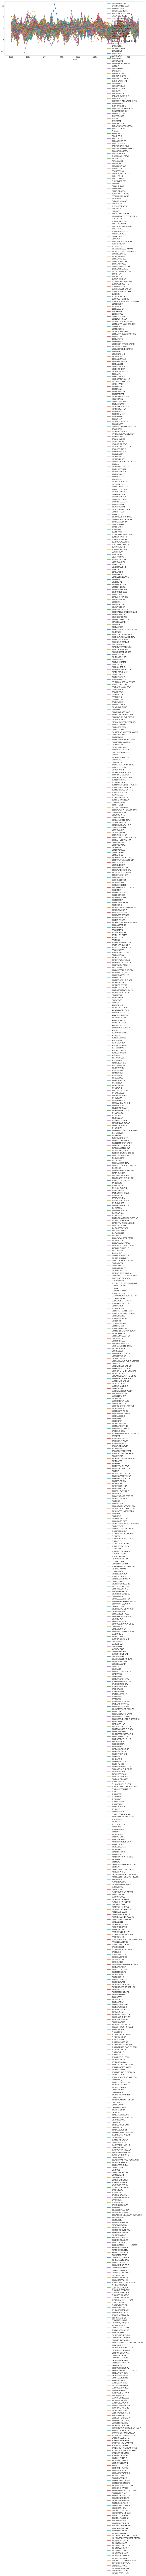

In [48]:
anom_df.plot(x='wyear', figsize=(15,6))

### Create Regression DataFrame

In [49]:
# Create Regression DataFrame
dat_df = pd.merge(anom_df, X_df, on='wyear')
dat_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38 entries, 0 to 37
Columns: 1054 entries, wyear to Nino_10
dtypes: float64(1053), int64(1)
memory usage: 313.2 KB


## Regularization / Lasso Model Selection

#### Generic function for any station :

In [50]:
def predOneStation(target, dat_df):
    # target = 'ZURICH (TOWN/'
    # 'target ~ PC1_ci_10 + PC2_z70_10 + PC3_sst_9' # Wang
    predNames = np.array(['PC1_z70_9',
     'PC2_z70_9',
     'PC3_z70_9',
     'PC1_ci_9',
     'PC2_ci_9',
     'PC3_ci_9',
     'PC1_sst_9',
     'PC2_sst_9',
     'PC3_sst_9', 
     'PC1_z70_10',  
     'PC2_z70_10', 
     'PC3_z70_10',
     'PC1_ci_10', 
     'PC2_ci_10',
     'PC3_ci_10',
     'PC1_sst_10',
     'PC2_sst_10',
     'PC3_sst_10',
     'PC1_sstna_10','PC2_sstna_10','PC3_sstna_10',
                          'Nino_9', 'Nino_10'])
    #ipdb.set_trace()
    dat_df = dat_df[dat_df[target].notnull()] # eliminate NA rows
    X = dat_df[predNames].as_matrix()
    # Target Variables:
    y = dat_df[[target]]
    y = np.ravel(y)
    # Before applying the Lasso, it is necessary to standardize the predictor
    scaler = StandardScaler()
    scaler.fit(X)
    X_stan = scaler.transform(X)
    # In order to find the optimal penalty parameter alpha,
    # use Cross-validated Lasso
    #modlcv = LassoLarsIC(criterion='aic')
    modlcv = LassoCV(cv=3, n_alphas=10000,max_iter=10000)
    modlcv.fit(X_stan, y)
    alpha = modlcv.alpha_

    # Name Of the non-null coefficients:
    # 'target ~ PC1_ci_10 + PC2_z70_10 + PC3_sst_9' # Wang
    ind = np.array(list(map(lambda x: float(x)!=0, modlcv.coef_)))
    importance_df = pd.DataFrame({'pred': predNames[ind], 
                                  'coef': modlcv.coef_[ind]})
    importance_df = importance_df.assign(absCoef=np.absolute(importance_df.coef))
    # According to the Lasso, the 3 strongest predictors are:
    # PC1_ci_10, PC2_z70_10, PC3_z70_9 
    importance_df.sort_values('absCoef', ascending=False)
    res = dict({'R2': modlcv.score(X_stan, y),'alpha': alpha, 'importance_df': importance_df})
    return(res)

#z = predOneStation(target='PAYERNE', dat_df=dat_df)
#z

In [51]:
z = map(predOneStation, sta_df.name)

In [52]:
for sta_name in colnames:
    z = predOneStation(target=sta_name, dat_df=dat_df)
    if z['R2'] > 0.5:
        print(sta_name, z)

0-FAIRHOPE 2 NE {'R2': 0.71139614309424415, 'alpha': 0.027194740601906072, 'importance_df':         coef          pred   absCoef
0   0.788031     PC1_z70_9  0.788031
1   0.711294     PC3_z70_9  0.711294
2   0.102891      PC1_ci_9  0.102891
3  -1.588115      PC2_ci_9  1.588115
4   0.249996     PC2_sst_9  0.249996
5  -0.600327    PC1_z70_10  0.600327
6   0.368339    PC2_z70_10  0.368339
7   0.020342    PC3_z70_10  0.020342
8  -0.940816     PC1_ci_10  0.940816
9   2.256007     PC2_ci_10  2.256007
10  0.098321     PC3_ci_10  0.098321
11 -0.214408  PC1_sstna_10  0.214408
12  0.213784  PC2_sstna_10  0.213784
13  0.364550  PC3_sstna_10  0.364550
14 -0.404466        Nino_9  0.404466}


/home/dmasson/anaconda3/envs/winter_predictor/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.



7-TALLADEGA {'R2': 0.85220669907441693, 'alpha': 0.017109332118638694, 'importance_df':         coef          pred   absCoef
0   1.160726     PC1_z70_9  1.160726
1   0.511365     PC2_z70_9  0.511365
2   0.895812     PC3_z70_9  0.895812
3  -2.791771      PC2_ci_9  2.791771
4  -0.234785      PC3_ci_9  0.234785
5   0.839569     PC2_sst_9  0.839569
6   0.140284     PC3_sst_9  0.140284
7  -0.545128    PC1_z70_10  0.545128
8   0.406458    PC2_z70_10  0.406458
9  -0.038146    PC3_z70_10  0.038146
10 -1.255680     PC1_ci_10  1.255680
11  3.549627     PC2_ci_10  3.549627
12  0.444360     PC3_ci_10  0.444360
13 -0.068558    PC2_sst_10  0.068558
14 -0.771204    PC3_sst_10  0.771204
15 -0.766771  PC1_sstna_10  0.766771
16  0.158986  PC2_sstna_10  0.158986
17  1.175024  PC3_sstna_10  1.175024
18 -0.752022        Nino_9  0.752022}


/home/dmasson/anaconda3/envs/winter_predictor/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

/home/dmasson/anaconda3/envs/winter_predictor/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

/home/dmasson/anaconda3/envs/winter_predictor/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.



41-FT BRAGG 5 N {'R2': 0.64149484881137719, 'alpha': 0.088439712476714727, 'importance_df':        coef          pred   absCoef
0 -0.348250     PC1_z70_9  0.348250
1 -0.010642     PC3_z70_9  0.010642
2  0.000035      PC3_ci_9  0.000035
3  0.170817     PC2_sst_9  0.170817
4 -0.092289     PC2_ci_10  0.092289
5 -0.069773     PC3_ci_10  0.069773
6 -0.500153  PC2_sstna_10  0.500153
7 -0.110003  PC3_sstna_10  0.110003}


/home/dmasson/anaconda3/envs/winter_predictor/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

/home/dmasson/anaconda3/envs/winter_predictor/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

/home/dmasson/anaconda3/envs/winter_predictor/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.



54-PASADENA {'R2': 0.79631210520240725, 'alpha': 0.0079289296715481742, 'importance_df':         coef          pred   absCoef
0  -0.274933     PC1_z70_9  0.274933
1  -0.263397     PC3_z70_9  0.263397
2   1.649897      PC2_ci_9  1.649897
3   0.900602      PC3_ci_9  0.900602
4  -0.880994     PC2_sst_9  0.880994
5  -0.217522     PC3_sst_9  0.217522
6  -0.258528    PC1_z70_10  0.258528
7   0.081696    PC2_z70_10  0.081696
8  -0.270137    PC3_z70_10  0.270137
9   0.178464     PC1_ci_10  0.178464
10 -1.271522     PC2_ci_10  1.271522
11 -0.657944     PC3_ci_10  0.657944
12  0.954386    PC2_sst_10  0.954386
13 -0.184308    PC3_sst_10  0.184308
14 -0.436024  PC2_sstna_10  0.436024
15 -0.348418  PC3_sstna_10  0.348418
16  0.584509        Nino_9  0.584509
17 -0.015748       Nino_10  0.015748}


/home/dmasson/anaconda3/envs/winter_predictor/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

/home/dmasson/anaconda3/envs/winter_predictor/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

/home/dmasson/anaconda3/envs/winter_predictor/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

/home/dmasson/anaconda3/envs/winter_predictor/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: Converge

94-OCALA {'R2': 0.73576766837175778, 'alpha': 0.072184666253288315, 'importance_df':         coef          pred   absCoef
0   0.511919     PC1_z70_9  0.511919
1   0.135881     PC3_z70_9  0.135881
2   0.117366      PC1_ci_9  0.117366
3  -0.050164      PC2_ci_9  0.050164
4   0.213408     PC1_sst_9  0.213408
5  -0.535540     PC2_sst_9  0.535540
6   0.073311    PC1_z70_10  0.073311
7   0.367717    PC3_z70_10  0.367717
8  -0.105068     PC1_ci_10  0.105068
9  -0.326826     PC3_ci_10  0.326826
10  0.347654    PC1_sst_10  0.347654
11 -0.022306    PC3_sst_10  0.022306
12  0.214655  PC2_sstna_10  0.214655
13 -0.578758  PC3_sstna_10  0.578758}


/home/dmasson/anaconda3/envs/winter_predictor/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

/home/dmasson/anaconda3/envs/winter_predictor/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.



98-TALLAHASSEE WSO AP {'R2': 0.69971996835831385, 'alpha': 0.028495734073230666, 'importance_df':         coef          pred   absCoef
0   0.926098     PC1_z70_9  0.926098
1   0.579439     PC3_z70_9  0.579439
2   0.011852      PC1_ci_9  0.011852
3  -1.977233      PC2_ci_9  1.977233
4   0.269709     PC2_sst_9  0.269709
5  -0.586061    PC1_z70_10  0.586061
6   0.261452    PC2_z70_10  0.261452
7  -0.670955     PC1_ci_10  0.670955
8   2.435851     PC2_ci_10  2.435851
9   0.092410     PC3_ci_10  0.092410
10 -0.542312  PC1_sstna_10  0.542312
11  0.424259  PC2_sstna_10  0.424259
12  0.289708  PC3_sstna_10  0.289708
13 -0.611765        Nino_9  0.611765}
100-ALBANY 3 SE {'R2': 0.7102220861488131, 'alpha': 0.021024795297992858, 'importance_df':         coef          pred   absCoef
0   0.939292     PC1_z70_9  0.939292
1   0.586341     PC3_z70_9  0.586341
2   0.180050      PC1_ci_9  0.180050
3  -2.513113      PC2_ci_9  2.513113
4  -0.222783      PC3_ci_9  0.222783
5   0.774205     PC2_sst_9  0.774

/home/dmasson/anaconda3/envs/winter_predictor/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.



105-GLENNVILLE 3NW {'R2': 0.77961736896693523, 'alpha': 0.017746247364741126, 'importance_df':         coef          pred   absCoef
0   1.100305     PC1_z70_9  1.100305
1   0.220574     PC2_z70_9  0.220574
2   0.525069     PC3_z70_9  0.525069
3   0.036202      PC1_ci_9  0.036202
4  -2.575827      PC2_ci_9  2.575827
5  -0.182390      PC3_ci_9  0.182390
6   0.074641     PC1_sst_9  0.074641
7   0.429580     PC2_sst_9  0.429580
8   0.029282     PC3_sst_9  0.029282
9  -0.605452    PC1_z70_10  0.605452
10  0.299929    PC2_z70_10  0.299929
11 -0.035106    PC3_z70_10  0.035106
12 -0.641923     PC1_ci_10  0.641923
13  2.656394     PC2_ci_10  2.656394
14  0.062429     PC3_ci_10  0.062429
15 -0.493613  PC1_sstna_10  0.493613
16  0.147290  PC2_sstna_10  0.147290
17  0.091320  PC3_sstna_10  0.091320
18 -0.138413        Nino_9  0.138413}


/home/dmasson/anaconda3/envs/winter_predictor/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

/home/dmasson/anaconda3/envs/winter_predictor/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

/home/dmasson/anaconda3/envs/winter_predictor/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

/home/dmasson/anaconda3/envs/winter_predictor/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: Converge

185-PRINCETON 1 W {'R2': 0.80564241707658935, 'alpha': 0.01405077432091135, 'importance_df':         coef          pred   absCoef
0   0.258769     PC1_z70_9  0.258769
1   0.720128     PC2_z70_9  0.720128
2   0.417660     PC3_z70_9  0.417660
3   1.681382      PC1_ci_9  1.681382
4  -4.182416      PC2_ci_9  4.182416
5  -1.661131      PC3_ci_9  1.661131
6  -1.583265     PC1_sst_9  1.583265
7   0.271605     PC2_sst_9  0.271605
8   0.717496     PC3_sst_9  0.717496
9  -0.683779    PC1_z70_10  0.683779
10  0.619573    PC2_z70_10  0.619573
11 -0.004071    PC3_z70_10  0.004071
12 -1.966501     PC1_ci_10  1.966501
13  4.129889     PC2_ci_10  4.129889
14  0.426560     PC3_ci_10  0.426560
15  0.348292    PC1_sst_10  0.348292
16  0.551913    PC2_sst_10  0.551913
17 -0.287049  PC1_sstna_10  0.287049
18 -0.464751  PC2_sstna_10  0.464751
19  0.642189  PC3_sstna_10  0.642189
20 -0.029672        Nino_9  0.029672
21 -1.776799       Nino_10  1.776799}


/home/dmasson/anaconda3/envs/winter_predictor/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.



KeyboardInterrupt: 